In [185]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer as CTGAN, TVAESynthesizer as TVAE
from sdv.sampling import Condition
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from pytorch_tabnet.tab_model import TabNetClassifier
from utils import manage_outlier

def seed_everything(seed:int=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

warnings.filterwarnings('ignore')
seed_everything()

In [168]:
df = pd.read_csv('./dataset/ff.csv')

def make_targets(targets):
    return 1 if targets >=5 else 0

df['BE3_31'] = df.apply(
    lambda row: make_targets(row['BE3_31']), axis=1
)
drops = df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100
df = df[drops[drops.values <= 10].index]
# feature importance 기반 변수 제거(1차)
df.drop(['LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL'], axis=1, inplace=True)
# corr matrix 기반 변수 제거(2차)
df.drop(['EC1_1'], axis=1, inplace=True)
# feature importance 기반 변수 제거(3차)
df.drop(['cage', 'LQ1_sb', 'LQ1_mn', 'LQ4_00'], axis=1, inplace=True)
# feture importance 기반 변수 제거(4차)
df.drop(['BD1', 'mh_stress', 'BS3_1'], axis=1, inplace=True)
# feture importance 기반 변수 제거(5차)
df.drop(['BO1_1', 'BO2_1'], axis=1, inplace=True)

In [169]:
# 1차년도
NUMERIC = ['HE_FEV1FVC', 'age', 'Total_slp_wk']
CATEGORICAL = ['sex', 'occp', 'EC1_1', 'cfam', 'marri_1', 'BH9_11', 'HE_DM', 'DC6_dg', 'DF2_dg', 'HE_HPdg', 'BP5']
ONE_HOT = ['BS3_1', 'edu', 'BP1', 'D_1_1', 'LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL', 'BO1_1', 'BO2_1']
# 2차년도
NUMERIC2 = ['DI1_ag', 'DE1_ag', 'LQ1_mn', 'BS6_2_1', 'BS6_3']
CATEGORICAL2 = ['DI1_pt', 'DE1_pt', 'DE1_3', 'BH1', 'BH2_61', 'LQ4_00', 'LQ4_05', 'LQ1_sb', 'MO1_wk', 'HE_cough1', 'HE_sput1', 'BD1', 'BD7_5', 'BP6_10', 'BP6_31']
ONE_HOT2 = ['DI1_2', 'EC_pedu_1', 'EC_pedu_2', 'BS5_1', 'BD7_4']
# 생성변수
NUMERIC3 = ['eq_5d']
CATEGORICAL3 = ['sm_present', 'mh_stress']
ONE_HOT3 = ['cage']
# Targets
TARGETS = ['BE3_31', 'BE5_1']

f_NUMERIC = (NUMERIC + NUMERIC2 + NUMERIC3).copy()
f_CATEGORICAL = (CATEGORICAL + CATEGORICAL2 + CATEGORICAL3).copy()
f_ONE_HOT = (ONE_HOT + ONE_HOT2 + ONE_HOT3).copy()
f_CATEGORICAL.append('BE5_1')

In [175]:
for value in f_NUMERIC:
    if value not in df.columns:
        print(value)
        f_NUMERIC.remove(value)

for value in f_CATEGORICAL:
    if value not in df.columns:
        print(value)
        f_CATEGORICAL.remove(value)

for value in f_ONE_HOT:
    if value not in df.columns:
        print(value)
        f_ONE_HOT.remove(value)

In [176]:
# 결측치 처리
for col in f_NUMERIC:
    df[col].fillna(0, inplace=True)
for col in f_CATEGORICAL:
    df[col].fillna(0, inplace=True)
for col in f_ONE_HOT:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [177]:
# 이상치 제거
for col in f_NUMERIC:
    print(col)
    manage_outlier(df, col)

HE_FEV1FVC
245개 삭제
age
0개 삭제
Total_slp_wk
28개 삭제
BS6_2_1
49개 삭제
BS6_3
220개 삭제
eq_5d
141개 삭제


In [178]:
X = df.drop('BE3_31', axis=1)
y = df['BE3_31']

X_numeric = X[f_NUMERIC]
X_categorical = X[f_CATEGORICAL]
X_onehot = X[f_ONE_HOT]
X_onehot = pd.get_dummies(X_onehot, dtype=float)

X = pd.concat([X_numeric, X_categorical], axis=1)
X = pd.concat([X, X_onehot], axis=1)
# split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

# scaler = StandardScaler()
scaler = MinMaxScaler()
train_X[f_NUMERIC] = scaler.fit_transform(train_X[f_NUMERIC])

test_X[f_NUMERIC] = scaler.transform(test_X[f_NUMERIC])

In [179]:
counts = np.bincount(train_y)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_y)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 1178 (47.63% of total)


In [33]:
smote = SMOTE(random_state=42)
sm_X, sm_y = smote.fit_resample(train_X, train_y)
counts = np.bincount(sm_y)
print(
    "Number of positive samples in smote(oversampling) data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(sm_y)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in smote(oversampling) data: 1578 (50.00% of total)


In [34]:
meta = train_X.copy()
meta['BE3_31'] = train_y

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=meta)

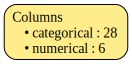

In [233]:
metadata.visualize(
    show_table_details='summarized',
    output_filepath='my_metadata.png'
)

In [53]:
ctgan = CTGAN(metadata, verbose=True, epochs=100)
ctgan.fit(meta)

Gen. (-2.78) | Discrim. (-0.01): 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]


In [161]:
# tvae = TVAE(metadata)
# tvae.fit(meta)

In [54]:
# conditional sampling
condition = Condition(
    num_rows=500,
    column_values={'BE3_31':1}
)
ctgan_sample = ctgan.sample_from_conditions(
    conditions=[condition]
)

condition2 = Condition(
    num_rows=500,
    column_values={'BE3_31':0}
)
ctgan_sample2 = ctgan.sample_from_conditions(
    conditions=[condition2]
)

Sampling conditions: 100%|██████████| 500/500 [00:00<00:00, 1491.98it/s]


In [164]:
# tvae_sample = tvae.sample_from_conditions(
#     conditions=[condition]
# )

Sampling conditions: 100%|██████████| 2200/2200 [00:10<00:00, 201.79it/s]


In [55]:
ctgan_X = train_X.copy()
ctgan_y = train_y.copy()
ctgan_X = ctgan_X.reset_index().drop('index', axis=1)
ctgan_y = ctgan_y.reset_index().drop('index', axis=1)

ctgan_X = pd.concat([ctgan_X, ctgan_sample.drop('BE3_31', axis=1)])
ctgan_X = pd.concat([ctgan_X, ctgan_sample2.drop('BE3_31', axis=1)])
ctgan_y = pd.concat([ctgan_y, ctgan_sample[['BE3_31']]])
ctgan_y = pd.concat([ctgan_y, ctgan_sample2[['BE3_31']]])

In [167]:
# tvae_X = train_X.copy()
# tvae_y = train_y.copy()
# tvae_X = tvae_X.reset_index().drop('index', axis=1)
# tvae_y = tvae_y.reset_index().drop('index', axis=1)

# tvae_X = pd.concat([tvae_X, tvae_sample.drop('BE5_1', axis=1)])
# tvae_y = pd.concat([tvae_y, tvae_sample[['BE5_1']]])

In [180]:
print(f'train shape: {train_X.shape, train_y.shape}')
# print(f'train(smote) shape: {sm_X.shape, sm_y.shape}')
# print(f'train(ctgan) shape: {ctgan_X.shape, ctgan_y.shape}')
# print(f'train(tvae) shape: {tvae_X.shape, tvae_y.shape}')
print(f'test shape: {test_X.shape, test_y.shape}')

train shape: ((2473, 33), (2473,))
test shape: ((619, 33), (619,))


In [194]:
import torch
model = TabNetClassifier(
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=.01),
)
model.fit(train_X.values, train_y.values, eval_set=[(test_X.values, test_y.values)], eval_metric=['accuracy'], 
          max_epochs=100, patience=50, batch_size=256, virtual_batch_size=64,)

epoch 0  | loss: 0.82074 | val_0_accuracy: 0.50081 |  0:00:00s
epoch 1  | loss: 0.71944 | val_0_accuracy: 0.56866 |  0:00:00s
epoch 2  | loss: 0.69769 | val_0_accuracy: 0.52989 |  0:00:00s
epoch 3  | loss: 0.69091 | val_0_accuracy: 0.54604 |  0:00:01s
epoch 4  | loss: 0.68463 | val_0_accuracy: 0.53312 |  0:00:01s
epoch 5  | loss: 0.67898 | val_0_accuracy: 0.54443 |  0:00:01s
epoch 6  | loss: 0.67905 | val_0_accuracy: 0.53312 |  0:00:02s
epoch 7  | loss: 0.67136 | val_0_accuracy: 0.52989 |  0:00:02s
epoch 8  | loss: 0.66918 | val_0_accuracy: 0.53473 |  0:00:02s
epoch 9  | loss: 0.67328 | val_0_accuracy: 0.54604 |  0:00:02s
epoch 10 | loss: 0.66633 | val_0_accuracy: 0.53796 |  0:00:03s
epoch 11 | loss: 0.66608 | val_0_accuracy: 0.53958 |  0:00:03s
epoch 12 | loss: 0.6667  | val_0_accuracy: 0.54443 |  0:00:03s
epoch 13 | loss: 0.66524 | val_0_accuracy: 0.54766 |  0:00:04s
epoch 14 | loss: 0.66094 | val_0_accuracy: 0.53796 |  0:00:04s
epoch 15 | loss: 0.66374 | val_0_accuracy: 0.53958 |  0

In [146]:
class ResidualBlock(layers.Layer):
    def __init__(self, hidden_dim):
        super(ResidualBlock, self).__init__()
        self.block1 = keras.Sequential([
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(.3),
            # keras.layers.ZeroPadding1D(padding=1),
            tfa.layers.WeightNormalization(keras.layers.Conv1D(hidden_dim, 3, 1, padding='same')),
            keras.layers.ReLU()
        ])

        self.block2 = keras.Sequential([
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(.2),
            # keras.layers.ZeroPadding1D(padding=2),
            tfa.layers.WeightNormalization(keras.layers.Conv1D(hidden_dim, 5, 1, padding='same')),
            keras.layers.ReLU()
        ])

    def call(self, x):
        inp_ = x
        x = self.block1(x)
        x = self.block2(x)
        out_ = x * inp_
        return out_
    

class CELU(layers.Layer):
    def __init__(self, alpha=1.0, **kwargs):
        super(CELU, self).__init__(**kwargs)
        self.alpha = alpha

    def call(self, x):
        positive = tf.nn.relu(x)
        negative = tf.clip_by_value(x, tf.float32.min, .0)
        negative = self.alpha * (tf.exp(negative / self.alpha) - 1)
        return positive + negative
    
    def get_config(self):
        config = super(CELU, self).get_config()
        config.update({'alpha': self.alpha})
        return config
    

class AdaptiveAvgPool1D(layers.Layer):
    def __init__(self, output_size, **kwargs):
        super(AdaptiveAvgPool1D, self).__init__(**kwargs)
        self.output_size = output_size

    def call(self, inputs):
        # 입력의 shape을 구합니다
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        channels = input_shape[2]

        # 새로운 크기를 계산합니다
        stride = input_shape[1] // self.output_size
        kernel_size = input_shape[1] - (self.output_size - 1) * stride

        # 평균 풀링을 적용합니다
        x = tf.reshape(inputs, [batch_size, self.output_size, kernel_size, channels])
        x = tf.reduce_mean(x, axis=2)
        return x

    def get_config(self):
        config = super(AdaptiveAvgPool1D, self).get_config()
        config.update({"output_size": self.output_size})
        return config

In [147]:
class NewModel(Model):
    def __init__(self, hidden_dim):
        super(NewModel, self).__init__()
        self.block1 = keras.Sequential([
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(.1),
            keras.layers.Dense(28 * 28, activation=CELU(alpha=.06)),

            keras.layers.Reshape((28, 28)),

            keras.layers.BatchNormalization(),
            keras.layers.Dropout(.1),
            keras.layers.ZeroPadding1D(padding=2),
            tfa.layers.WeightNormalization(keras.layers.Conv1D(hidden_dim, 5, 1)),
            keras.layers.ReLU(),

            AdaptiveAvgPool1D(32),

            keras.layers.BatchNormalization(),
            keras.layers.Dropout(.1),
            keras.layers.ZeroPadding1D(padding=1),
            tfa.layers.WeightNormalization(keras.layers.Conv1D(hidden_dim, 3, 1)),
            keras.layers.ReLU(),
        ])
        self.residual = ResidualBlock(256)
        self.block2 = keras.Sequential([
            keras.layers.ZeroPadding1D(padding=1),
            keras.layers.MaxPool1D(4, 2),
            keras.layers.Flatten(),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(.2),
            tfa.layers.WeightNormalization(keras.layers.Dense(1))
        ])

    def call(self, x):
        x = self.block1(x)
        x = self.residual(x)
        x = self.block2(x)
        return x

In [148]:
model = NewModel(256)
metrics = [
    keras.metrics.BinaryAccuracy(name="acc"),
]
loss = keras.losses.BinaryCrossentropy()
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss=loss, metrics=metrics
)
callback = keras.callbacks.ModelCheckpoint('./auto.h5', mode='max', monitor='val_acc', save_best_only=True)
# class_weight = {0: weight_for_0, 1: weight_for_1*2}

In [149]:
train_X.shape

(2473, 33)

In [150]:
model.build(input_shape=(None, 33))

In [151]:
model.summary()

Model: "new_model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_22 (Sequential)  (None, 32, 256)           494358    
                                                                 
 residual_block_3 (Residual  multiple                  1052162   
 Block)                                                          
                                                                 
 sequential_25 (Sequential)  (None, 1)                 24580     
                                                                 
Total params: 1571100 (5.99 MB)
Trainable params: 799388 (3.05 MB)
Non-trainable params: 771712 (2.94 MB)
_________________________________________________________________


In [164]:
model = keras.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(.1),
    keras.layers.Dropout(.1),
    keras.layers.Dense(28*28, activation=CELU(alpha=.06)),

    keras.layers.Reshape((28, 28, 1)),
    
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(.1),
    tfa.layers.WeightNormalization(keras.layers.Conv1D(128, 3, 1, padding='same')),
    keras.layers.ReLU(),
    
    ResidualBlock(128),

    keras.layers.BatchNormalization(),
    keras.layers.Dropout(.1),
    tfa.layers.WeightNormalization(keras.layers.Conv1D(128, 3, 1, padding='same')),
    keras.layers.ReLU(),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])
metrics = [
    keras.metrics.BinaryAccuracy(name="acc"),
]
loss = keras.losses.BinaryCrossentropy()
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss=loss, metrics=metrics
)
callback = keras.callbacks.ModelCheckpoint('./auto.h5', mode='max', monitor='val_acc', save_best_only=True)
# class_weight = {0: weight_for_0, 1: weight_for_1*2}

In [165]:
hist = model.fit(
    train_X,
    # train_X,
    # to_categorical(train_y),
    # train_y,
    train_y,
    batch_size=128,
    epochs=50,
    # validation_data=(test_X, to_categorical(test_y)),
    validation_data=(test_X, test_y),
    # class_weight=class_weight,
    callbacks=[callback]
)

Epoch 1/50


2023-12-28 08:04:54.428567: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_32/dropout_59/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


20/20 [==============================] - 7s 109ms/step - loss: 0.8128 - acc: 0.5180 - val_loss: 0.6901 - val_acc: 0.5267
Epoch 2/50
20/20 [==============================] - 1s 48ms/step - loss: 0.7279 - acc: 0.5746 - val_loss: 0.6898 - val_acc: 0.5460
Epoch 3/50
20/20 [==============================] - 1s 43ms/step - loss: 0.7346 - acc: 0.5819 - val_loss: 0.6893 - val_acc: 0.5250
Epoch 4/50
20/20 [==============================] - 1s 48ms/step - loss: 0.7067 - acc: 0.5956 - val_loss: 0.6892 - val_acc: 0.5670
Epoch 5/50
20/20 [==============================] - 1s 43ms/step - loss: 0.6850 - acc: 0.5936 - val_loss: 0.6896 - val_acc: 0.5428
Epoch 6/50
20/20 [==============================] - 1s 43ms/step - loss: 0.7056 - acc: 0.5863 - val_loss: 0.6964 - val_acc: 0.4766
Epoch 7/50
20/20 [==============================] - 1s 43ms/step - loss: 0.6842 - acc: 0.6110 - val_loss: 0.6970 - val_acc: 0.4814
Epoch 8/50
20/20 [==============================] - 1s 43ms/step - loss: 0.6743 - acc: 0.6247

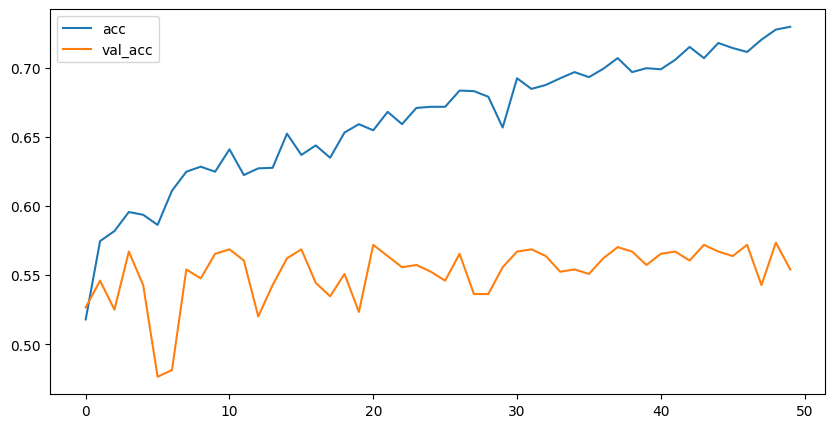

In [166]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['acc', 'val_acc'])

In [197]:
print(classification_report(test_y, model.predict(test_X.values)))

              precision    recall  f1-score   support

           0       0.58      0.76      0.66       324
           1       0.59      0.38      0.47       295

    accuracy                           0.58       619
   macro avg       0.59      0.57      0.56       619
weighted avg       0.58      0.58      0.57       619



In [90]:
pred = model.predict(train_X)
pred = np.squeeze(np.where(pred >.5, 1, 0))
print(classification_report(train_y, pred))

95/95 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1578
           1       0.80      0.80      0.80      1442

    accuracy                           0.81      3020
   macro avg       0.81      0.81      0.81      3020
weighted avg       0.81      0.81      0.81      3020



In [91]:
pred = model.predict(test_X)
pred = np.squeeze(np.where(pred >.5, 1, 0))
print(classification_report(test_y, pred))

24/24 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.61      0.60      0.60       394
           1       0.57      0.57      0.57       361

    accuracy                           0.59       755
   macro avg       0.59      0.59      0.59       755
weighted avg       0.59      0.59      0.59       755



In [92]:
md = keras.models.load_model('./auto.h5')
pred = md.predict(train_X)
pred = np.squeeze(np.where(pred >.5, 1, 0))
print(classification_report(train_y, pred))

95/95 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1578
           1       0.66      0.61      0.64      1442

    accuracy                           0.67      3020
   macro avg       0.66      0.66      0.66      3020
weighted avg       0.66      0.67      0.66      3020



In [93]:
md = keras.models.load_model('./auto.h5')
pred = md.predict(test_X)
pred = np.squeeze(np.where(pred >.5, 1, 0))
print(classification_report(test_y, pred))

24/24 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.63      0.68      0.65       394
           1       0.62      0.55      0.58       361

    accuracy                           0.62       755
   macro avg       0.62      0.62      0.62       755
weighted avg       0.62      0.62      0.62       755



<Axes: >

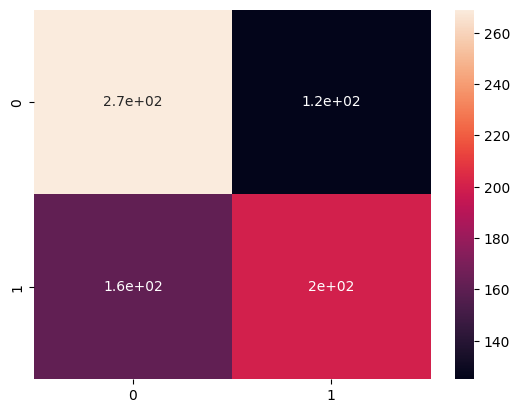

In [94]:
sns.heatmap(confusion_matrix(test_y, pred), annot=True)

In [98]:
# pred = model.predict(val_X)
pred = np.squeeze(np.where(model.predict(val_X) >= .5, 1, 0))
# print(classification_report(tf.argmax(pred, axis=1), val_y))
print(classification_report(pred, val_y))

19/19 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.72      0.91      0.81       419
           1       0.44      0.16      0.24       176

    accuracy                           0.69       595
   macro avg       0.58      0.54      0.52       595
weighted avg       0.64      0.69      0.64       595



In [99]:
# pred = model.predict(test_X)
pred = np.squeeze(np.where(model.predict(test_X) >= .5, 1, 0))
# print(classification_report(tf.argmax(pred, axis=1), test_y))
print(classification_report(pred, test_y))

5/5 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.63      0.93      0.75        89
           1       0.65      0.18      0.29        60

    accuracy                           0.63       149
   macro avg       0.64      0.56      0.52       149
weighted avg       0.64      0.63      0.56       149



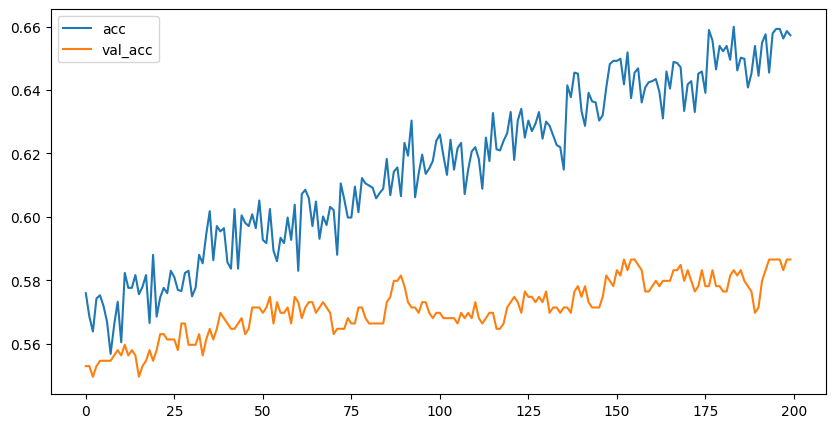

In [91]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['acc', 'val_acc'])

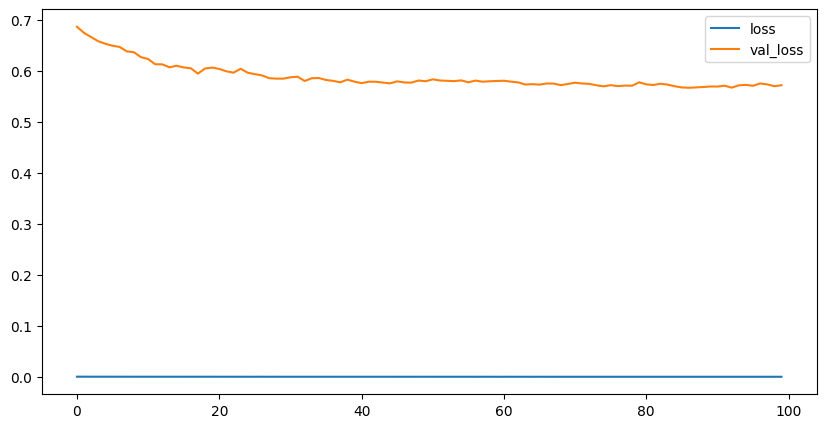

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])